loaded: 0
loaded: 500
loaded: 1000
loaded: 1500
loaded: 2000
loaded: 2500
loaded: 3000
loaded: 3500
loaded: 4000
loaded: 4500
loaded: 5000
loaded: 5500
loaded: 6000
loaded: 6500
loaded: 7000
loaded: 7500
loaded: 8000
loaded: 8500
loaded: 9000
loaded: 9500
loaded: 10000
loaded: 10500
loaded: 11000
loaded: 11500
loaded: 12000
loaded: 12500
loaded: 13000
loaded: 13500
loaded: 14000
loaded: 14500
loaded: 15000
loaded: 15500
loaded: 16000
loaded: 16500
loaded: 17000
loaded: 17500
loaded: 18000
loaded: 18500
loaded: 19000
loaded: 19500
loaded: 20000
loaded: 20500
loaded: 21000
loaded: 21500
loaded: 22000
loaded: 22500
loaded: 23000
loaded: 23500
loaded: 24000
loaded: 24500
loaded: 25000
loaded: 25500
loaded: 26000
loaded: 26500
loaded: 27000
loaded: 27500
loaded: 28000
loaded: 28500
loaded: 29000
loaded: 29500
loaded: 30000
loaded: 30500
loaded: 31000
loaded: 31500
loaded: 32000
loaded: 32500
loaded: 33000
loaded: 33500
loaded: 34000
loaded: 34500
loaded: 35000
loaded: 35500
loaded: 36000
lo

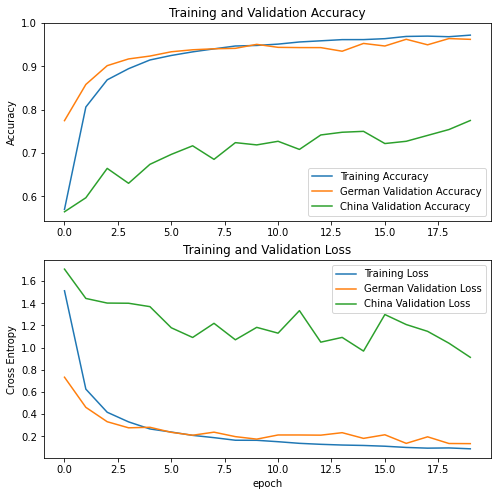

In [5]:
# import packages
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback
import argparse

# create neural network
class RoadSignClassifier:
    def createCNN(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        model.add(Conv2D(8, (5, 5), input_shape=inputShape, activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(classes, activation="softmax"))
        return model


# load data
data_path_training = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/Combined Dataset/"
def load_training_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        # print(img_path)
        # print(img_class)
        # print(i)
        # print(row)
        image = os.path.join(data_path_training, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(img_class)
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

data_path_testing= r"/Users/hdai/Documents/Junior Year/SML310/Final Project/Combined Dataset/Combined Total - separated"      
def load_testing_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    # print(rows)
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        # print(img_path)
        # print(img_class)
        image = os.path.join(data_path_testing, img_path)
        image = cv2.imread(image)
        # print(image)
        image_rs = cv2.resize(image, (32, 32), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image)
        classes.append(int(img_class))
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=1, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", default="output/collaborativetrafficsignnet.model", help="path to output model")
#args = vars(ap.parse_args())


epochs = 20
learning_rate = 0.001
batch_size = 64

#Run this part for the first time and save the pre-processed data. So you do not have to process it every time
train_data = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/Combined Dataset/Combined Total - separated/Combined training only correct.csv"
test_data_China = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/Combined Dataset/Combined Total - separated/TSRD Test separated correct.csv"
test_data_German = r"/Users/hdai/Documents/Junior Year/SML310/Final Project/Combined Dataset/Combined Total - separated/GTSRB test separated.csv"
(train_X, train_Y) = load_training_data(train_data)
np.save('Collaborative_trainX',train_X)
np.save('Collaborative_trainY',train_Y)
(test_X_German, test_Y_German) = load_testing_data(test_data_German)
np.save('Collaborative_GTSD_testX',test_X_German)
np.save('Collaborative_GTSD_testY',test_Y_German)
(test_X_China, test_Y_China) = load_testing_data(test_data_China)
np.save('Collaborative_TSRD_testX',test_X_China)
np.save('Collaborative_TSRD_testY',test_Y_China)


#train_X = np.load('Collaborative_trainX.npy', allow_pickle=True)
#train_Y = np.load('Collaborative_trainY.npy', allow_pickle=True)
#test_X_China = np.load('Collaborative_TSRD_testX.npy', allow_pickle=True)
#test_Y_China = np.load('Collaborative_TSRD_testY.npy', allow_pickle=True)
#test_X_German = np.load('Collaborative_GTSD_testX.npy', allow_pickle=True)
#test_Y_German = np.load('Collaborative_GTSD_testY.npy', allow_pickle=True)
print("UPDATE: Normalizing data")
trainX = train_X.astype("float32") / 255.0
testX_China = test_X_China.astype("float32") / 255.0
testX_German = test_X_German.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(train_Y))
trainY = to_categorical(train_Y, num_labels)
testY_China = to_categorical(test_Y_China, num_labels)
testY_German = to_categorical(test_Y_German, num_labels)

class_totals = trainY.sum(axis=0)
class_weight = class_totals.max() / class_totals

# data augmentation
data_aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
vertical_flip=False)

# train model
model = RoadSignClassifier.createCNN(width=32, height=32, depth=3, classes=num_labels)
optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs))
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

history = AdditionalValidationSets([(testX_China, testY_China, 'val2')])

fit = model.fit(
    data_aug.flow(trainX, trainY, batch_size=batch_size), 
    epochs=epochs,
    validation_data=(testX_German, testY_German),
    # class_weight=class_weight,
    callbacks=[history],
    verbose=1)

model.save("output/collaborativetrafficsignnet.model")

acc = history.history['accuracy']
val_acc_German = history.history['val_accuracy']
val_acc_China = history.history['val2_accuracy']

loss = history.history['loss']
val_loss_German = history.history['val_loss']
val_loss_China = history.history['val2_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc_German, label='German Validation Accuracy')
plt.plot(val_acc_China, label='China Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss_German, label='German Validation Loss')
plt.plot(val_loss_China, label='China Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

np.save('Collaborative_German_and_China_mc6', [acc,loss,val_acc_German,val_loss_German,val_acc_China,val_loss_China])





In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 8)         608       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 16)        1168      
                                                                 
 batch_normalization_4 (Batc  (None, 12, 12, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 batch_normalization_5 (Batc  (None, 10, 10, 16)      

In [7]:
len(np.unique(train_Y))

66